In [1]:
import numpy as np
import keras.backend as K

from keras.layers import  GlobalAveragePooling1D, Input, Activation, MaxPooling1D, BatchNormalization, Dense, Dropout, Conv1D,GlobalMaxPooling1D
from keras.layers import GRU,AveragePooling1D,CuDNNGRU
from keras.layers.merge import Concatenate
from keras.models import Model 
from keras.callbacks import EarlyStopping,ModelCheckpoint

import keras.backend.tensorflow_backend as KTF
import tensorflow as tf
import os


os.environ["CUDA_VISIBLE_DEVICES"] = "0"

config = tf.ConfigProto()
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess = tf.Session(config=config)

KTF.set_session(sess)


Using TensorFlow backend.
/home/xhh/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/xhh/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/xhh/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/xhh/anaconda3/envs/py36/lib/p

In [2]:
with open('CD9.fasta', 'r') as f:
    all_protseqs = f.readlines()

In [3]:
prot2seq = {}
for line in all_protseqs:
    if line.startswith('>'):
        key = line.rstrip()[1:]
        prot2seq[key] = ''
    else:
        prot2seq[key] += line.rstrip()

        
        

In [4]:
keys = list(prot2seq.keys())
print(keys)

['CD9', 'CD 53', 'CD 63 antigen', 'KIT', 'CD 36', 'CD 9 partner', 'Tetraspanin 4', 'Integrin alpha 3', 'CD81 antigen', 'CD 19', 'CD 59', 'Protein Kinase C alpha', 'Collagen binding protein 2', 'ADAM2', 'CD 81 Partner 3', 'DTS', 'Integrin alpha 5']


In [5]:
prot_name_2_ID = {}
prot_name_2_ID['CD9'] = 'P21926'
prot_name_2_ID['CD 53'] =  'P19397'
prot_name_2_ID['CD 63 antigen'] = 'P08962'
prot_name_2_ID['KIT'] = 'P10721'
prot_name_2_ID['CD 36'] = 'P16671'
prot_name_2_ID['CD 9 partner'] = 'Q9P2B2' 

prot_name_2_ID['Tetraspanin 4'] = 'O14817'
prot_name_2_ID['Integrin alpha 3'] = 'P26006'
prot_name_2_ID['CD81 antigen'] = 'P60033'
prot_name_2_ID['CD 19'] = 'P15391'
prot_name_2_ID['CD 59'] = 'P13987'
prot_name_2_ID['Protein Kinase C alpha'] = 'P17252'
prot_name_2_ID['Collagen binding protein 2'] = 'P17252'
prot_name_2_ID['ADAM2'] = 'Q99965'

prot_name_2_ID['CD 81 Partner 3'] = 'Q969P0'
prot_name_2_ID['DTS'] = 'Q99075'
prot_name_2_ID['Integrin alpha 5'] = 'P08648'



In [6]:
import requests, sys
import json
from tqdm import tqdm
ppi_go_terms = {}
remain_proteins = []
for t in tqdm(keys):
    protID = prot_name_2_ID[t]
    requestURL = "https://www.ebi.ac.uk/QuickGO/services/annotation/search?geneProductId="+protID
    r = requests.get(requestURL, headers={ "Accept" : "application/json"})
    if r.ok:
        responseBody = r.text
        data=json.loads(responseBody)
        for k in data['results']: 
            go_id = k['goId'] 
            if t not in ppi_go_terms.keys():
                ppi_go_terms[t] = go_id
            else:
                ppi_go_terms[t] = ppi_go_terms[t] + ';' + go_id
        if len(data['results']) == 0:
            remain_proteins.append(t)
    else:
        remain_proteins.append(t)

100%|██████████| 17/17 [00:41<00:00,  2.44s/it]


In [7]:
remain_proteins

[]

In [8]:
class TermVectors:
    def __init__(self):
        self.termVectorDict=dict()
        self.terms=None
        self.vectors=None

    def parse_term_embedding_file(self,file_path):
        with open(file_path) as f:
            lines=f.readlines()
            self.vectors=lines[1:] # 第一个是term的数量，不是termID
            terms = []
            for line in lines[1:]:
                term=line.split()[0]
                terms.append(term)
            self.terms = terms

    def str_to_vector(self,Str):
        Str = Str.strip('\n')
        nums = Str.split()
        vec = []
        for num in nums:
            vec.append(float(num))
        return np.array(vec)

    def construct_term_vector_dict(self):
        for term in self.terms:
            termindex = self.terms.index(term)
            line=self.vectors[termindex]
            s =line[len(term):].lstrip(' ')
            s_vec =self.str_to_vector(s)
            self.termVectorDict[term]=s_vec

In [9]:
# construct Node2Vec termVector
BP_TERM_EMB_FILE_PATH = '/home/xhh/PPI/Node2Vec/EDGELIST/BP.emb'
CC_TERM_EMB_FILE_PATH = '/home/xhh/PPI/Node2Vec/EDGELIST/CC.emb'
MF_TERM_EMB_FILE_PATH = '/home/xhh/PPI/Node2Vec/EDGELIST/MF.emb'
Node2Vec_dim = 300


BPTermVectors = TermVectors()
BPTermVectors.parse_term_embedding_file(BP_TERM_EMB_FILE_PATH)
BPTermVectors.construct_term_vector_dict()
print(len(BPTermVectors.termVectorDict))

CCTermVectors = TermVectors()
CCTermVectors.parse_term_embedding_file(CC_TERM_EMB_FILE_PATH)
CCTermVectors.construct_term_vector_dict()
print(len(CCTermVectors.termVectorDict))

MFTermVectors = TermVectors()
MFTermVectors.parse_term_embedding_file(MF_TERM_EMB_FILE_PATH)
MFTermVectors.construct_term_vector_dict()
print(len(MFTermVectors.termVectorDict))

29699
4202
11148


In [10]:
# read go.obo obtain ontology type
id_type_dicts = {}
obo_file = '/home/xhh/PPI/cross-species/go.obo'
fp=open(obo_file,'r')
obo_txt=fp.read()
fp.close()
obo_txt=obo_txt[obo_txt.find("[Term]")-1:]
obo_txt=obo_txt[:obo_txt.find("[Typedef]")]
# obo_dict=parse_obo_txt(obo_txt)
id_type_dicts = {}
for Term_txt in obo_txt.split("[Term]\n"):
    if not Term_txt.strip():
        continue
    name = ''
    ids = []
    for line in Term_txt.splitlines():
        if   line.startswith("id: "):
            ids.append(line[len("id: "):])     
        elif line.startswith("namespace: "):
             name=line[len("namespace: "):]
        elif line.startswith("alt_id: "):
            ids.append(line[len("alt_id: "):])
    
    for t_id in ids:
        id_type_dicts[t_id] = name

In [11]:
import numpy as np
alphabet = np.array(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
                     'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'])

def label_sequence(line, MAX_SEQ_LEN, smi_ch_ind):
	X = np.zeros(MAX_SEQ_LEN)

	for i, ch in enumerate(line[:MAX_SEQ_LEN]):
		X[i] = smi_ch_ind[ch]

	return X #.tolist()

def letter_one_hot(aa):
    one_hot = np.zeros(20)
    for idx, letter in enumerate(alphabet):
        if aa == letter:
            one_hot[idx] = 1
            return one_hot


# Convert an entire protein to one-hot representation.
def protein_one_hot(protein_sequence, MAX_SEQ_LEN):
    #  Remove non-specific AA codes (very few are actually present in this dataset)
    protein_sequence = protein_sequence.replace('B', '')
    protein_sequence = protein_sequence.replace('J', '')
    protein_sequence = protein_sequence.replace('O', '')
    protein_sequence = protein_sequence.replace('U', '')
    protein_sequence = protein_sequence.replace('X', '')
    protein_sequence = protein_sequence.replace('Z', '')
    one_hot_seq = np.zeros( (MAX_SEQ_LEN, 20))
    for idx, aa in enumerate(protein_sequence[:MAX_SEQ_LEN]):
        one_hot_seq[idx, :] = letter_one_hot(aa)
    return one_hot_seq


In [12]:
import keras
feature_len = 768
max_go_len = 128
max_seq_len = 1000
max_node_len = 32

In [13]:
from keras import backend as K, initializers, regularizers, constraints
from keras.engine.topology import Layer


def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        # todo: check that this is correct
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)


class Attention(Layer):
    def __init__(self,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False,
                 **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Note: The layer has been tested with Keras 1.x
        Example:
            # 1
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
            # next add a Dense layer (for classification/regression) or whatever...
            # 2 - Get the attention scores
            hidden = LSTM(64, return_sequences=True)(words)
            sentence, word_scores = Attention(return_attention=True)(hidden)
        """
        self.supports_masking = True
        self.return_attention = return_attention
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        eij = dot_product(x, self.W)

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        weighted_input = x * K.expand_dims(a)

        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]

In [14]:
from keras.layers import   Embedding
from keras.layers import  GRU, Bidirectional, CuDNNGRU, Lambda, dot, Flatten, CuDNNLSTM, Add
from keras.layers.merge import concatenate

def inception_block(input_tensor, output_size):
    """"""
    con1d_filters = int(output_size/4)
    y = Conv1D(con1d_filters, 3, activation="relu", padding='same')(input_tensor)
    x1 = Conv1D(con1d_filters, 5, activation="relu", padding='same')(y)

    y = Conv1D(con1d_filters, 1, activation="relu", padding='valid')(input_tensor)
    x2 = Conv1D(con1d_filters, 3, activation="relu", padding='same')(y)

    x3 = Conv1D(con1d_filters, 3, activation="relu", padding='same')(input_tensor)
    x4 = Conv1D(con1d_filters, 1, activation="relu", padding='same')(input_tensor)

    y = Concatenate()([x1, x2, x3, x4])
#     y = MaxPooling1D(2)(mix0)
    # y = AveragePooling1D()(mix0)
#     y = BatchNormalization()(y)

    return y

In [23]:
 
def build_cnn_gru_model(input_x, con_filters, gru_units):
    x = inception_block(input_x,con_filters )
    x = Dropout(0.3)(x)
    x_gru = Bidirectional(CuDNNGRU(gru_units, return_sequences=True))(input_x)
    x_gru = Dropout(0.3)(x_gru)
     
    x_a = GlobalAveragePooling1D()(x)
    x_b = GlobalMaxPooling1D()(x)
    x_c = Attention()(x)
    x_gru_a = GlobalAveragePooling1D()(x_gru)
    x_gru_b = GlobalMaxPooling1D()(x_gru)
    x_gru_c = Attention()(x_gru)
    x = Concatenate()([x_a,x_b,x_c,   x_gru_a, x_gru_b,   x_gru_c])
    x = Dense(256)(x)
    return x
def build_model():
    con_filters = 128
    gru_units = 64
    left_input_go = Input(shape=(max_go_len,feature_len))
    right_input_go = Input(shape=(max_go_len,feature_len))
    
    left_input_node = Input(shape=(max_node_len,Node2Vec_dim))
    right_input_node = Input(shape=(max_node_len,Node2Vec_dim))
    
    
    left_input_seq = Input(shape=(max_seq_len,20))
    right_input_seq = Input(shape=(max_seq_len,20))
    

    left_x_go = build_cnn_gru_model(left_input_go, con_filters, gru_units)
    right_x_go = build_cnn_gru_model(right_input_go, con_filters,gru_units)
    
    left_x_seq = build_cnn_gru_model(left_input_seq, con_filters, gru_units)
    right_x_seq = build_cnn_gru_model(right_input_seq, con_filters, gru_units)
    
    left_x_node = build_cnn_gru_model(left_input_node, con_filters, gru_units)
    right_x_node = build_cnn_gru_model(right_input_node, con_filters,gru_units)
    
   
    
   
   
    x =   Concatenate()([left_x_go  , right_x_go, left_x_node,  right_x_node, left_x_seq, right_x_seq])
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(512, activation='relu')(x)
  
    x = Dense(1)(x)
    output = Activation('sigmoid')(x)
    # model = Model([left_input_go, right_input_go], output)
  
    model = Model([left_input_go, right_input_go, left_input_node, right_input_node,     left_input_seq, right_input_seq], output)
#     model = multi_gpu_model(model)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


 

model = build_model()
model.summary() 

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 128, 768)     0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 128, 768)     0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 32, 300)      0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 32, 300)      0                                            
____________________________________________________________________________________________

In [16]:
alphabet = np.array(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
                     'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'])

 

def letter_one_hot(aa):
    one_hot = np.zeros(20)
    for idx, letter in enumerate(alphabet):
        if aa == letter:
            one_hot[idx] = 1
            return one_hot


# Convert an entire protein to one-hot representation.
def protein_one_hot(protein_sequence, MAX_SEQ_LEN):
    #  Remove non-specific AA codes (very few are actually present in this dataset)
    protein_sequence = protein_sequence.replace('B', '')
    protein_sequence = protein_sequence.replace('J', '')
    protein_sequence = protein_sequence.replace('O', '')
    protein_sequence = protein_sequence.replace('U', '')
    protein_sequence = protein_sequence.replace('X', '')
    protein_sequence = protein_sequence.replace('Z', '')
    one_hot_seq = np.zeros( (MAX_SEQ_LEN, 20))
    for idx, aa in enumerate(protein_sequence[:MAX_SEQ_LEN]):
        one_hot_seq[idx, :] = letter_one_hot(aa)
    return one_hot_seq


In [17]:
protein2onehot = {}
for key, value in prot2seq.items():
    protein2onehot[key] =  protein_one_hot(value, max_seq_len) 

In [18]:
with open('CD9','r') as f:
    postive_samples = f.readlines()

In [19]:
ppi_pairs = []
for key1, value1 in prot2seq.items():
    for key2, value2 in prot2seq.items():
        if key1 != key2 and key1 == 'CD9':
            ppi_pair = key1 + ':' + key2 + '\n'
            if ppi_pair in postive_samples:
                ppi_pair = key1 + ':' + key2 + ':1\n'
            else:
                ppi_pair = key1 + ':' + key2 + ':0\n'
            if key2 == 'Integrin alpha 5':
                ppi_pair = key1 + ':' + key2 + ':1\n'
            ppi_pairs.append(ppi_pair)
            
    
    

In [20]:
prot2nodevec = {}
for key, value in ppi_go_terms.items():
    X_go1 =  np.zeros((1,Node2Vec_dim))
    allgos = value.split(';') 
    allgos = list(set(allgos))
    count = 0
    for  go in  allgos:
        if go.startswith('GO'):
            if id_type_dicts[go] == 'biological_process':
                termVectors = BPTermVectors
                term_ID=go[3:].lstrip('0')
                if term_ID in termVectors.termVectorDict.keys():
                    feature = termVectors.termVectorDict[term_ID].reshape(1, Node2Vec_dim)
                else:
                    feature = np.zeros((1,Node2Vec_dim))
                
            elif id_type_dicts[go] == 'cellular_component':
                termVectors = CCTermVectors
                term_ID=go[3:].lstrip('0')
                if term_ID in termVectors.termVectorDict.keys():
                    feature = termVectors.termVectorDict[term_ID].reshape(1, Node2Vec_dim)
                else:
                    feature = np.zeros((1,Node2Vec_dim))
            elif id_type_dicts[go] == 'molecular_function':
                termVectors = MFTermVectors
                term_ID=go[3:].lstrip('0')
                if term_ID in termVectors.termVectorDict.keys():
                    feature = termVectors.termVectorDict[term_ID].reshape(1, Node2Vec_dim)
                else:
                    feature = np.zeros((1,Node2Vec_dim))
            else:
                 
                feature = np.zeros((1,Node2Vec_dim))


            if count + feature.shape[0] > max_node_len:
                break
            X_go1 = np.concatenate((X_go1,feature ))    
            count += feature.shape[0]
    prot2nodevec[key] =  X_go1[1:]  

In [21]:
prot2emb = {}
for key, value in ppi_go_terms.items():
    X_go1 =  np.zeros((1,768))
    allgos = value.split(';') 
    allgos = list(set(allgos))
    count = 0
    for  go in  allgos:
        if go.startswith('GO'):
            feature = np.load('../../ncbi_allfeatures4go/'+go+'_0.npy')[1:-1]
            if count + feature.shape[0] > max_go_len:
                break
            X_go1 = np.concatenate((X_go1,feature ))    
            count += feature.shape[0]
    prot2emb[key] =  X_go1[1:]   

# with open('CD9', 'r') as infile:
#     ppi_pairs = infile.readlines()
    
X_go1 = np.empty((len(ppi_pairs), max_go_len,768))        
X_go2 = np.empty((len(ppi_pairs), max_go_len,768))
y = np.empty((len(ppi_pairs)))
        
X_seq1 = np.empty((len(ppi_pairs), max_seq_len,20))
X_seq2 = np.empty((len(ppi_pairs), max_seq_len,20))

X_node1 = np.empty((len(ppi_pairs), max_node_len,Node2Vec_dim))        
X_node2 = np.empty((len(ppi_pairs), max_node_len,Node2Vec_dim))


for i, ppi_pair in enumerate(ppi_pairs):
     
    p1, p2, label = ppi_pair.rstrip().split(':')
#     y[i] = 1
    if label == '1':
        y[i] = 1
    else:
        y[i] = 0

    feature = prot2emb[p1]
    X_go1[i,:feature.shape[0]] = feature

    feature = prot2emb[p2]
    X_go2[i,:feature.shape[0]] = feature

    X_seq1[i] =  protein2onehot[p1]
    X_seq2[i] =  protein2onehot[p2]
    
    
    prot1emb_node = prot2nodevec[p1]
    X_node1[i,:prot1emb_node.shape[0]] = prot1emb_node
            
    prot2emb_node = prot2nodevec[p2]
    X_node2[i,:prot2emb_node.shape[0]] = prot2emb_node

In [24]:
model.load_weights('/home/xhh/PPI/SC_CV/node2vec_bert_GoplusSeq0-0.hdf5')

y_pred_prob = model.predict([X_go1, X_go2, X_node1, X_node2,  X_seq1, X_seq2])
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
y_pred = (y_pred_prob > 0.5)
y_test = y
# auc = metrics.roc_auc_score(y_test, y_pred_prob) 
f1 = f1_score(y_test, y_pred)
pre = precision_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(acc)

1.0


In [25]:
y_pred

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

In [26]:
y_test

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [27]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

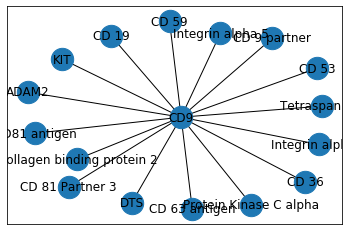

In [28]:
G = nx.DiGraph()
G.add_edges_from(
    [('CD9', 'CD 53'), ('CD9', 'CD 63 antigen'), ('CD9', 'KIT'), ('CD9', 'CD 36'), ('CD9', 'CD 9 partner'),
     ('CD9', 'Tetraspanin 4'), ('CD9', 'Integrin alpha 3'), ('CD9', 'CD81 antigen'), ('CD9', 'CD 19'),
     ('CD9', 'CD 59'), ('CD9', 'Protein Kinase C alpha'), ('CD9', 'Collagen binding protein 2'),
     ('CD9', 'ADAM2'), ('CD9', 'CD 81 Partner 3'), ('CD9', 'DTS'), ('CD9', 'Integrin alpha 5'),])

# val_map = {'A': 1.0,
#            'D': 0.5714285714285714,
#            'H': 0.0}

# values = [val_map.get(node, 0.25) for node in G.nodes()]

# Specify the edges you want here
# red_edges = [('A', 'C'), ('E', 'C')]
# edge_colours = ['black' if not edge in red_edges else 'red'
#                 for edge in G.edges()]
black_edges = [edge for edge in G.edges()  ]

# Need to create a layout when doing
# separate calls to draw nodes and edges
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                         node_size = 500)
nx.draw_networkx_labels(G, pos)
# nx.draw_networkx_edges(G, pos, edgelist=red_edges, edge_color='r', arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=black_edges, arrows=False)